**Load Dataset**

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import os

#Load dari file simpanan hasil preproses dalam bentuk .pt
class MultimodalDeepfakeDataset(Dataset):
    def __init__(self, pt_folder):
        self.pt_files = [os.path.join(pt_folder, f) for f in os.listdir(pt_folder) if f.endswith('.pt')]

    def __len__(self):
        return len(self.pt_files)

    def __getitem__(self, idx):
        data = torch.load(self.pt_files[idx])
        frames = data['frames']          # (T, 3, 224, 224)
        audio = data['audio']            # (1, F, T)
        
        # Normalisasi data audio
        if audio.max() > 1.0 or audio.min() < 0.0:
            audio = torch.clamp(audio, min=-80, max=0) 
            audio = (audio + 80) / 80
            
        label = data['label']
        return frames, audio, torch.tensor(label, dtype=torch.long)

In [2]:
def collate_fn_pad(batch):
    # batch: list of tuples (frames, audio, label)
    max_len = max(frames.shape[0] for frames, _, _ in batch)

    padded_frames = []
    padded_audio = []
    labels = []

    for frames, audio, label in batch:
        T = frames.shape[0]
        pad_T = max_len - T

        # Pad frames: (T, 3, 224, 224) → (max_len, 3, 224, 224)
        if pad_T > 0:
            pad = torch.zeros(pad_T, 3, 224, 224)
            frames = torch.cat([frames, pad], dim=0)

            # Pad audio: (1, 128, T) → (1, 128, max_len)
            audio_pad = torch.zeros(1, 128, pad_T)
            audio = torch.cat([audio, audio_pad], dim=2)

        padded_frames.append(frames)
        padded_audio.append(audio)
        labels.append(label)

    # Stack semua jadi batch tensor
    frames_batch = torch.stack(padded_frames)  # (B, max_len, 3, 224, 224)
    audio_batch = torch.stack(padded_audio)    # (B, 1, 128, max_len)
    labels_batch = torch.stack(labels)         # (B,)
    return frames_batch, audio_batch, labels_batch


In [ ]:
# DataLoader
dataset = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, collate_fn=collate_fn_pad)
val_loader   = DataLoader(val_set, batch_size=4, shuffle=False, collate_fn=collate_fn_pad)

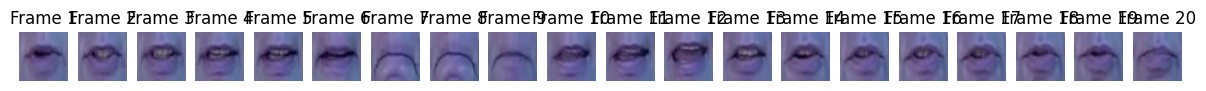


Menampilkan spectrogram audio:


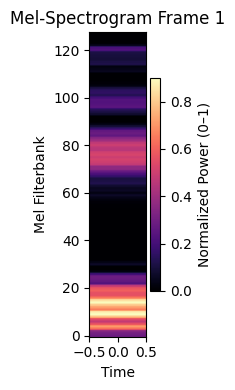

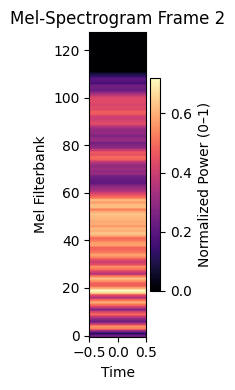

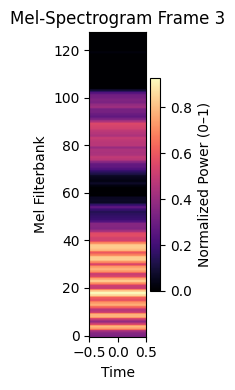

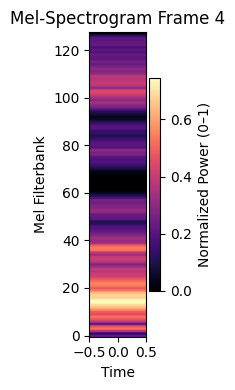

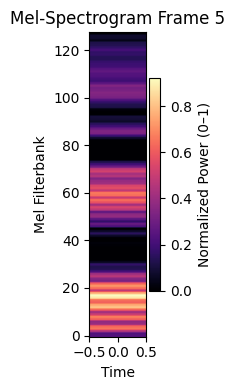

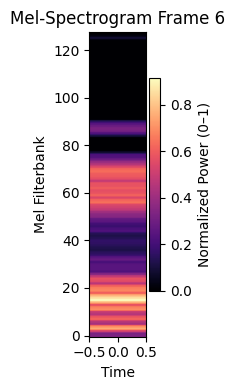

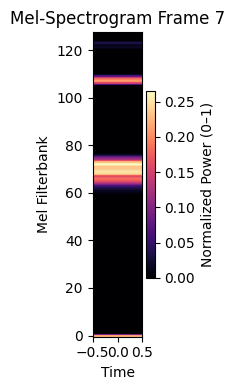

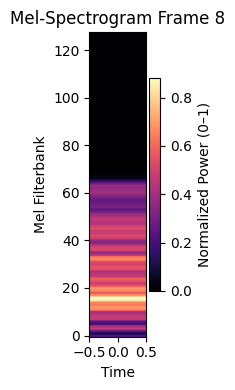

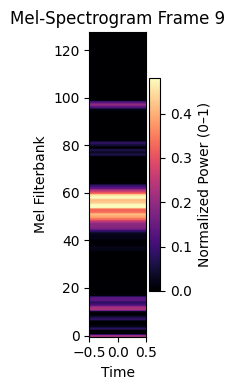

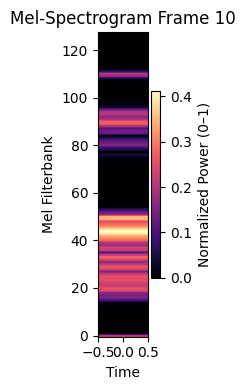

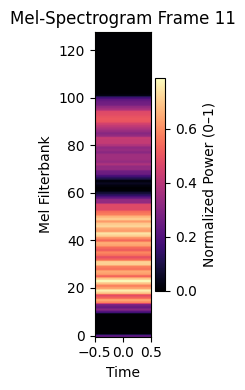

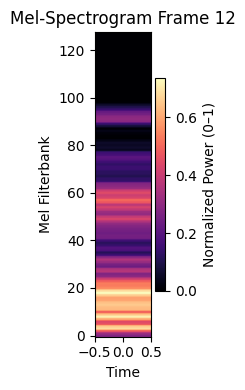

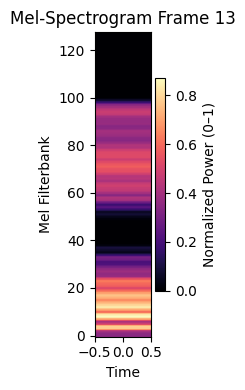

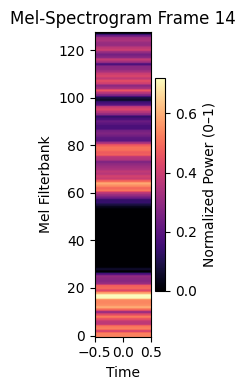

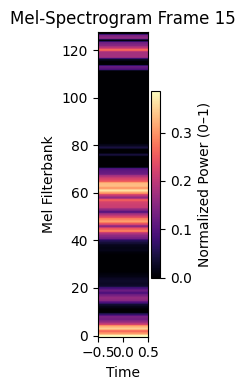

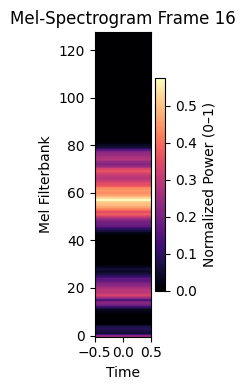

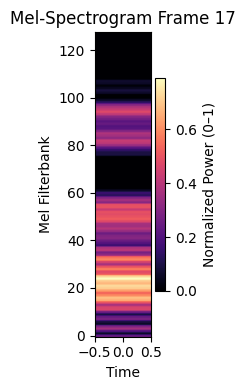

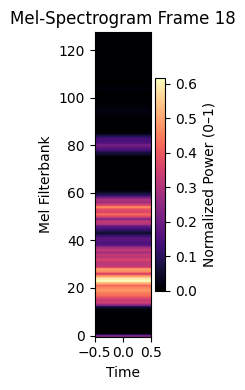

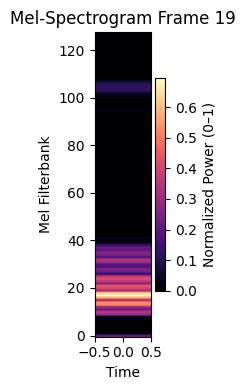

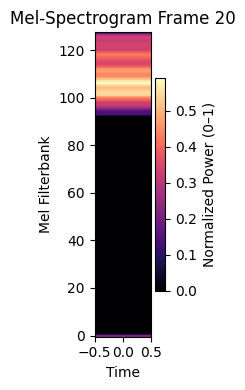

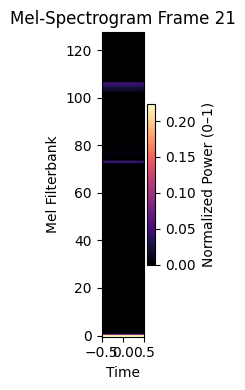

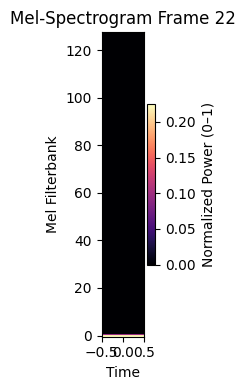

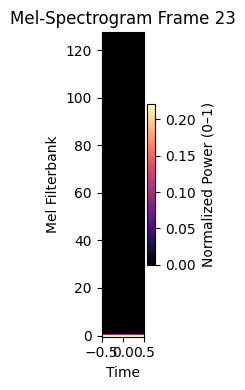

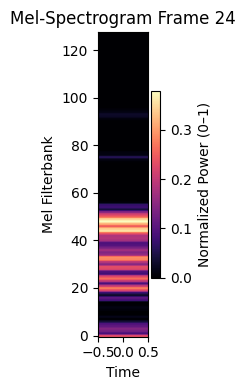

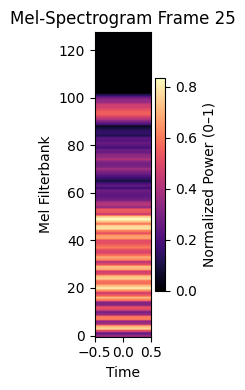

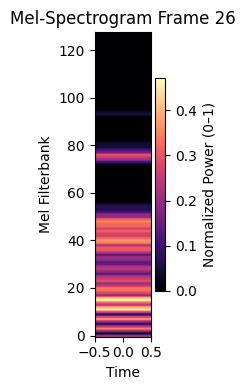

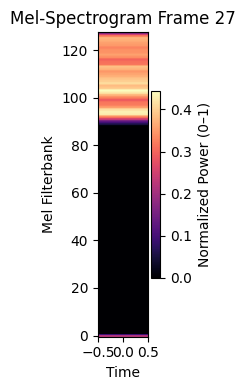

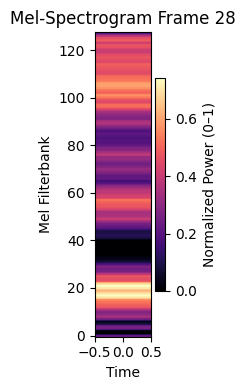

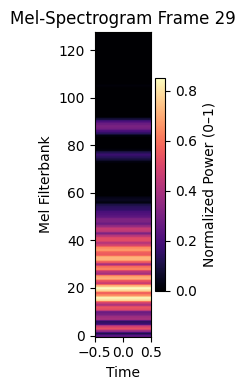

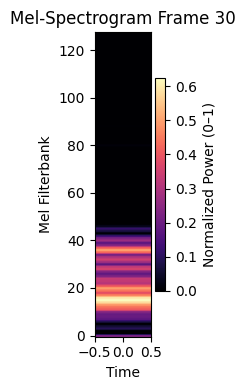

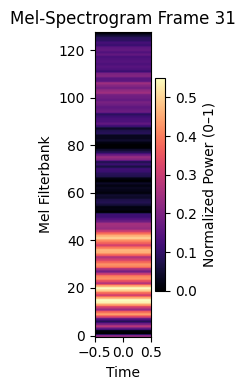

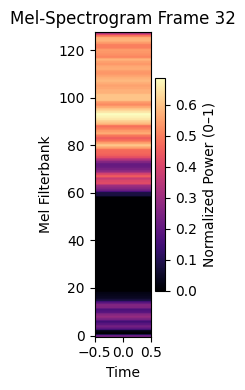

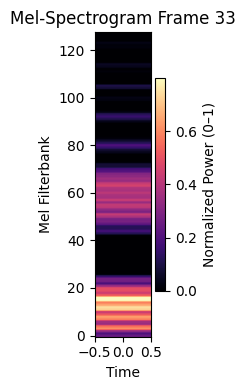

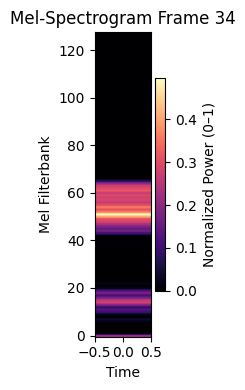

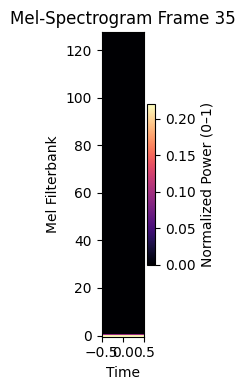

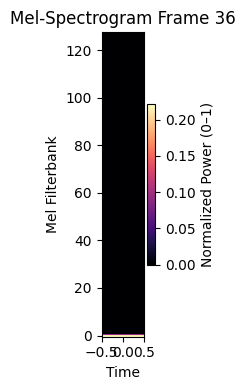

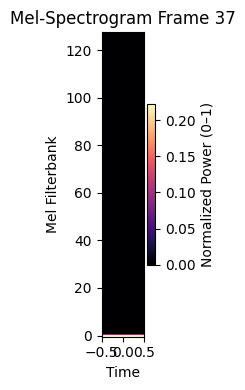

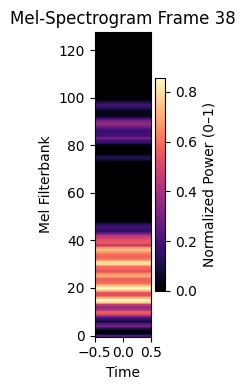

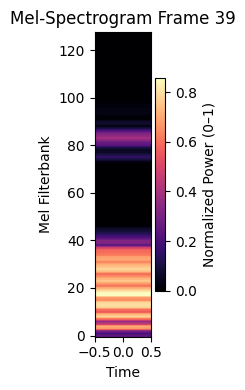

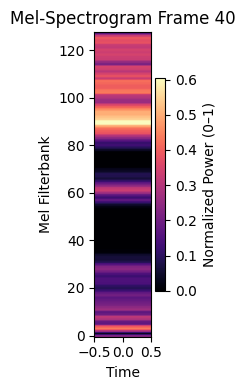

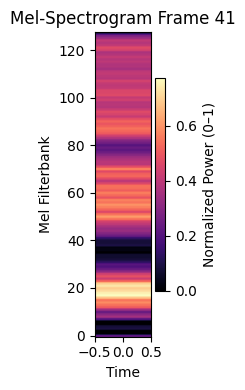

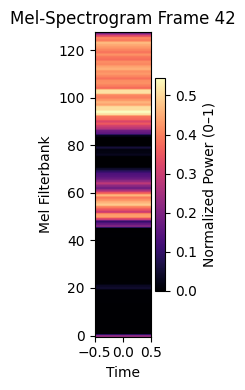

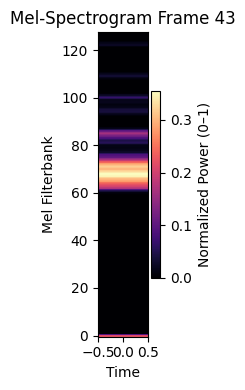

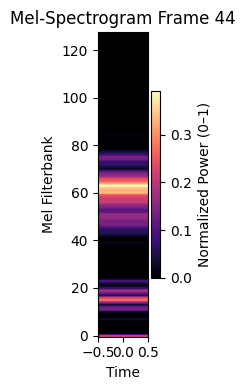

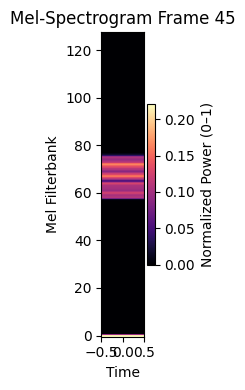

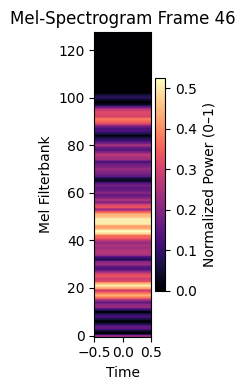

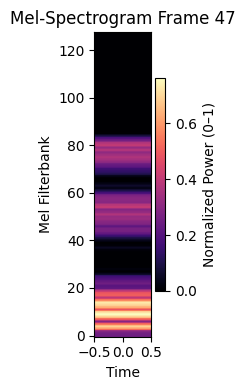

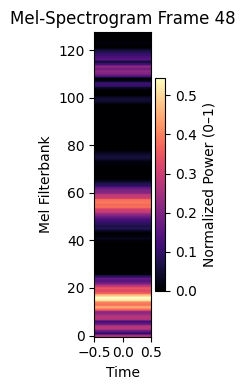

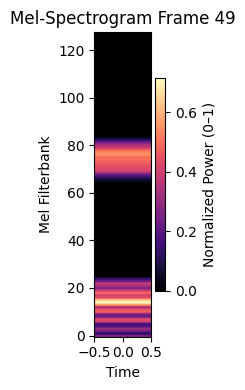

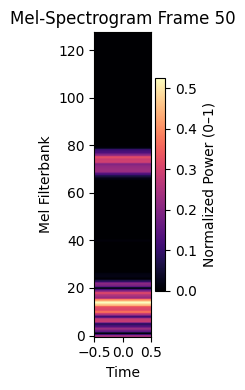

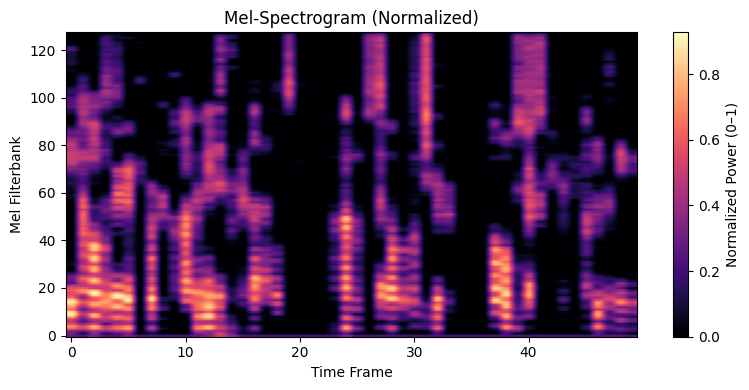

In [ ]:
import matplotlib.pyplot as plt

# Fungsi untuk preview 1 sample dataset
def preview_dataset(dataset, idx=0):
    frames, audio, label = dataset[idx]

    # Tampilkan 5 frame pertama
    num_frames_to_show = min(20, frames.size(0))
    fig, axes = plt.subplots(1, num_frames_to_show, figsize=(15, 5))
    
    for i in range(num_frames_to_show):
        img = frames[i].permute(1, 2, 0).numpy()  # (H, W, 3)
        img = (img * 255).astype('uint8')

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Frame {i+1}")

    plt.show()
        
    # Plot audio spectrogram
    print("\nMenampilkan spectrogram audio:")
    spectrogram = audio.squeeze(0).cpu().numpy()

    # Misal spectrogram shape: (1, 128, 50)
    if isinstance(audio, torch.Tensor):
        spectrogram = audio.squeeze().numpy()  # (128, 50)

    for t in range(50):
        frame = spectrogram[:, t].reshape(-1, 1)  # Ubah jadi (128, 1) agar bisa di-plot

        plt.figure(figsize=(2, 4))
        plt.imshow(frame, aspect='auto', origin='lower', cmap='magma')
        plt.title(f"Mel-Spectrogram Frame {t+1}")
        plt.xlabel("Time")
        plt.ylabel("Mel Filterbank")
        plt.colorbar(label="Normalized Power (0–1)")
        plt.tight_layout()
        plt.show()
    
    if isinstance(spectrogram, torch.Tensor):
        spectrogram = spectrogram.squeeze().numpy()

    # Plot hanya 50 frame pertama
    plt.figure(figsize=(8, 4))
    plt.imshow(spectrogram[:, :50], aspect='auto', origin='lower', cmap='magma')
    plt.title("Mel-Spectrogram (Normalized)")
    plt.xlabel("Time Frame")
    plt.ylabel("Mel Filterbank")
    plt.colorbar(label="Normalized Power (0–1)")
    plt.tight_layout()
    plt.show()

# Contoh pakai train_dataset
preview_dataset(train_set, idx=2)

**ResNet18-BiLSTM**

**Percobaan 1**

ResNet18 : Bibir (4 Sequential Block + 1 BiLSTM)  + Audio (Custom 128 Filter Conv + 1 BiLSTM)

1 BiLSTM 

In [ ]:
from torchvision import models
import torch.nn as nn

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = x.view(B, T, -1)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 128)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=128,
                            batch_first=True, bidirectional=True)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze(2).permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Fitur Temporal Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion = nn.LSTM(input_size=512+256, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang (opsional)
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out, _ = self.temporal_fusion(fused)      # (B, T, 512)
        pooled = fused_out.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.eval()

MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/ResNet18-BiLSTM_Bibir-Audio/4SequentialResNet18-Bibir_Custom128-Audio_BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/40] Train Loss: 0.7007 | Train Acc: 0.4627 | Val Loss: 0.7000 | Val Acc: 0.4925
Epoch [2/40] Train Loss: 0.6911 | Train Acc: 0.5373 | Val Loss: 0.7077 | Val Acc: 0.4925
Epoch [3/40] Train Loss: 0.6878 | Train Acc: 0.5560 | Val Loss: 0.6980 | Val Acc: 0.4478
Epoch [4/40] Train Loss: 0.6795 | Train Acc: 0.5709 | Val Loss: 0.6024 | Val Acc: 0.7463
Epoch [5/40] Train Loss: 0.6032 | Train Acc: 0.7015 | Val Loss: 0.5381 | Val Acc: 0.7463
Epoch [6/40] Train Loss: 0.5682 | Train Acc: 0.7537 | Val Loss: 0.5478 | Val Acc: 0.7761
Epoch [7/40] Train Loss: 0.5421 | Train Acc: 0.7500 | Val Loss: 0.4907 | Val Acc: 0.7761
Epoch [8/40] Train Loss: 0.5206 | Train Acc: 0.7351 | Val Loss: 0.5235 | Val Acc: 0.7761
Epoch [9/40] Train Loss: 0.4961 | Train Acc: 0.7649 | Val Loss: 0.5363 | Val Acc: 0.7463
Epoch [10/40] Train Loss: 0.5111 | Train Acc: 0.7575 | Val Loss: 0.4676 | Val Acc: 0.7761
Epoch [11/40] Train Loss: 0.5113 | Train Acc: 0.7724 | Val Loss: 0.4710 | Val Acc: 0.7910
Epoch [12/40] Train

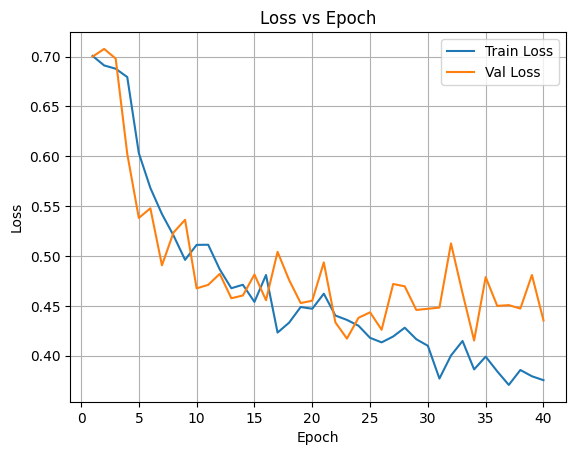

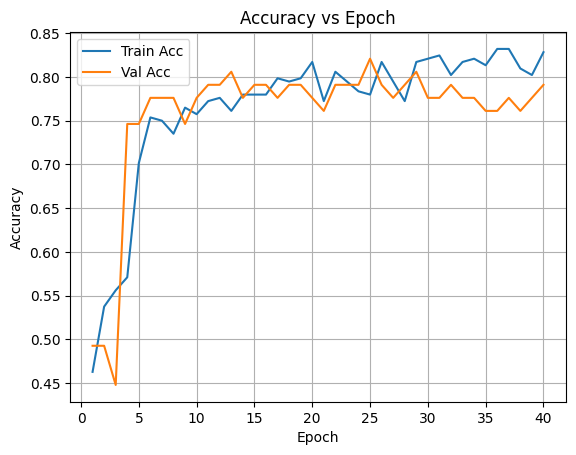

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

tensor([[[[0.2715, 0.2397, 0.1681,  ..., 0.1680, 0.1661, 0.2643],
          [0.5079, 0.4791, 0.0866,  ..., 0.0000, 0.0000, 0.4201],
          [0.5792, 0.4768, 0.1525,  ..., 0.0000, 0.0000, 0.4655],
          ...,
          [0.4515, 0.3161, 0.0000,  ..., 0.1751, 0.0000, 0.3077],
          [0.3957, 0.2403, 0.0000,  ..., 0.1383, 0.0000, 0.2180],
          [0.2586, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0224]]]],
       device='cuda:0')
tensor([[[[0.4106, 0.2002, 0.3738,  ..., 0.1713, 0.2019, 0.4003],
          [0.6271, 0.2517, 0.6207,  ..., 0.1502, 0.3111, 0.6223],
          [0.6789, 0.3653, 0.6577,  ..., 0.1866, 0.3804, 0.6130],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1219, 0.0595, 0.0905],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]],
       device='cuda:0')
tensor([[[[0.4195, 0.3690, 0.2333,  ..., 0.1463, 0.1281, 0.1278],
          [0.4774, 0.4691, 0.2322,  ..., 0.0879, 0.0000, 0

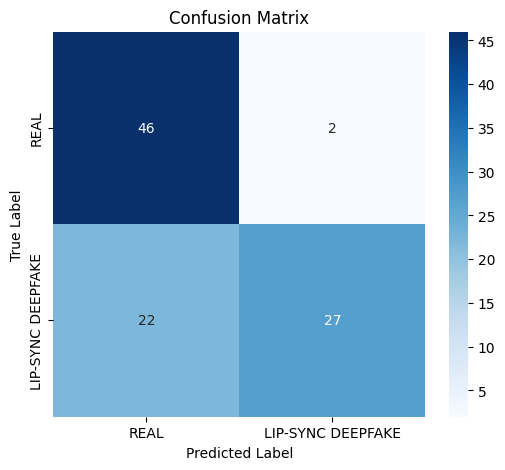

=== ROC AUC ===

📈 AUC Score: 0.7989


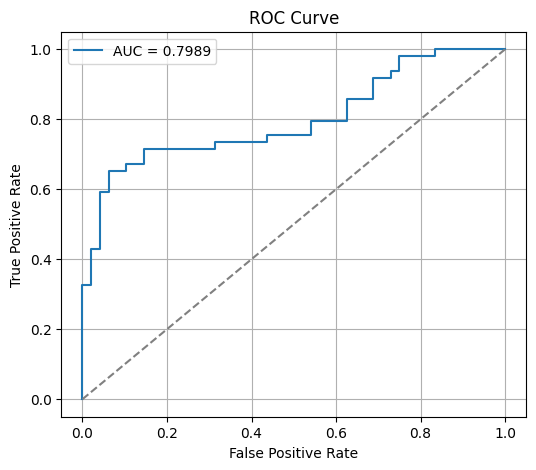

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/ResNet18-BiLSTM_Bibir-Audio/4SequentialResNet18-Bibir_Custom128-Audio_BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)

        print(audio)
        
        outputs = model(frames, audio)
        
        probs = torch.softmax(outputs, dim=1)
        probs_class1.extend(probs[:, 1].cpu().numpy())

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        pred_labels.extend(preds)
        true_labels.extend(true)
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 2**

ResNet18 : Bibir (3 Sequential Block + 1 BiLSTM)  + Audio (128 Custom CNN + 1 BiLSTM)

1 BiLSTM 

In [ ]:
from torchvision import models
import torch.nn as nn

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(base.children())[:-3])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = x.view(B, T, -1)  # (B, T, 512)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 128)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=128,
                            batch_first=True, bidirectional=True)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze(2).permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        return lstm_out

# Model Gabungan dan Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion = nn.LSTM(input_size=512+256, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out, _ = self.temporal_fusion(fused)      # (B, T, 512)
        pooled = fused_out.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/ResNet18-BiLSTM_Bibir-Audio/3SequentialResNet18-Bibir_Custom128-Audio_BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch [1/40] Train Loss: 0.6949 | Train Acc: 0.4776 | Val Loss: 0.6933 | Val Acc: 0.5075
Epoch [2/40] Train Loss: 0.6943 | Train Acc: 0.4590 | Val Loss: 0.6942 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6934 | Train Acc: 0.5299 | Val Loss: 0.6918 | Val Acc: 0.5522
Epoch [4/40] Train Loss: 0.6912 | Train Acc: 0.5187 | Val Loss: 0.6829 | Val Acc: 0.5075
Epoch [5/40] Train Loss: 0.6543 | Train Acc: 0.6455 | Val Loss: 0.5054 | Val Acc: 0.7463
Epoch [6/40] Train Loss: 0.5572 | Train Acc: 0.7276 | Val Loss: 0.5351 | Val Acc: 0.6866
Epoch [7/40] Train Loss: 0.5052 | Train Acc: 0.7612 | Val Loss: 0.5543 | Val Acc: 0.7164
Epoch [8/40] Train Loss: 0.5178 | Train Acc: 0.7724 | Val Loss: 0.5211 | Val Acc: 0.7463
Epoch [9/40] Train Loss: 0.4709 | Train Acc: 0.7724 | Val Loss: 0.4627 | Val Acc: 0.8209
Epoch [10/40] Train Loss: 0.4856 | Train Acc: 0.7425 | Val Loss: 0.4705 | Val Acc: 0.7761
Epoch [11/40] Train Loss: 0.4387 | Train Acc: 0.7910 | Val Loss: 0.5935 | Val Acc: 0.6866
Epoch [12/40] Train

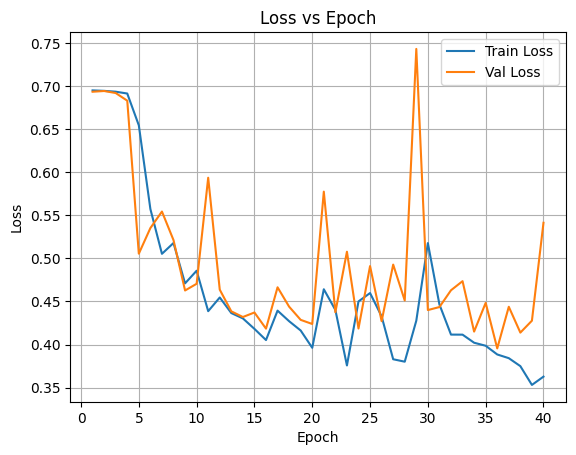

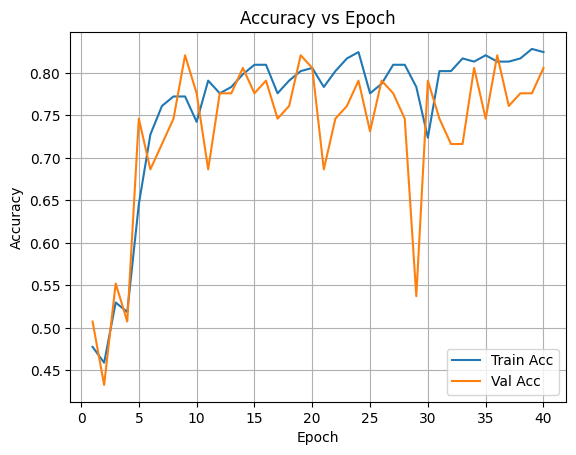

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.68      0.96      0.79        48
LIP-SYNC DEEPFAKE       0.93      0.55      0.69        49

         accuracy                           0.75        97
        macro avg       0.80      0.75      0.74        97
     weighted avg       0.81      0.75      0.74        97

=== CONFUSION MATRIX ===


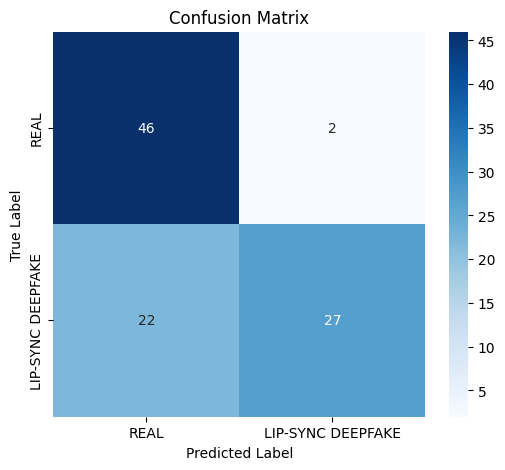

=== ROC AUC ===

📈 AUC Score: 0.8363


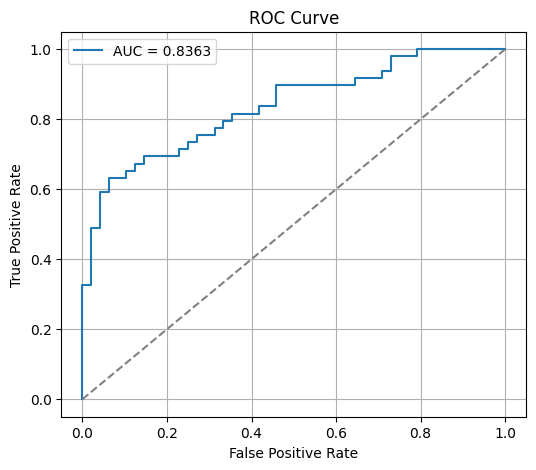

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/ResNet18-BiLSTM_Bibir-Audio/3SequentialResNet18-Bibir_Custom128-Audio_BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
        
        outputs = model(frames, audio)
        
        probs = torch.softmax(outputs, dim=1)
        probs_class1.extend(probs[:, 1].cpu().numpy())

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        pred_labels.extend(preds)
        true_labels.extend(true)
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 3**

ResNet18 : Bibir (2 Sequential Block + 1 BiLSTM)  + Audio (128 Custom CNN + 1 BiLSTM)

1 BiLSTM 

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(base.children())[:-4])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 512)
        x = x.view(B, T, -1)  # (B, T, 512)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 128)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=128,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Gabungan dan Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion = nn.LSTM(input_size=512+256, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out, _ = self.temporal_fusion(fused)      # (B, T, 512)
        pooled = fused_out.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/ResNet18-BiLSTM_Bibir-Audio/2SequentialResNet18-Bibir_Custom128-Audio_BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch [1/40] Train Loss: 0.6945 | Train Acc: 0.5075 | Val Loss: 0.6937 | Val Acc: 0.4925
Epoch [2/40] Train Loss: 0.6929 | Train Acc: 0.5149 | Val Loss: 0.6918 | Val Acc: 0.4925
Epoch [3/40] Train Loss: 0.6896 | Train Acc: 0.5410 | Val Loss: 0.6854 | Val Acc: 0.4925
Epoch [4/40] Train Loss: 0.6641 | Train Acc: 0.6306 | Val Loss: 0.7940 | Val Acc: 0.4925
Epoch [5/40] Train Loss: 0.6011 | Train Acc: 0.7164 | Val Loss: 0.4870 | Val Acc: 0.7761
Epoch [6/40] Train Loss: 0.5624 | Train Acc: 0.7201 | Val Loss: 0.4888 | Val Acc: 0.8060
Epoch [7/40] Train Loss: 0.5094 | Train Acc: 0.7724 | Val Loss: 0.5025 | Val Acc: 0.7761
Epoch [8/40] Train Loss: 0.4864 | Train Acc: 0.7687 | Val Loss: 0.4870 | Val Acc: 0.7761
Epoch [9/40] Train Loss: 0.4735 | Train Acc: 0.7873 | Val Loss: 0.5092 | Val Acc: 0.8060
Epoch [10/40] Train Loss: 0.5198 | Train Acc: 0.7313 | Val Loss: 0.4683 | Val Acc: 0.7761
Epoch [11/40] Train Loss: 0.4612 | Train Acc: 0.7836 | Val Loss: 0.4710 | Val Acc: 0.7761
Epoch [12/40] Train

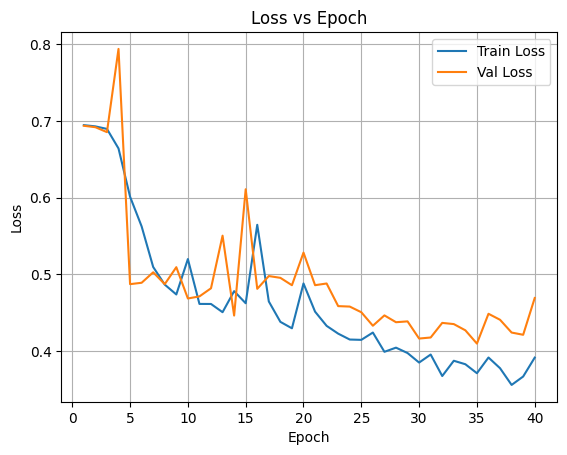

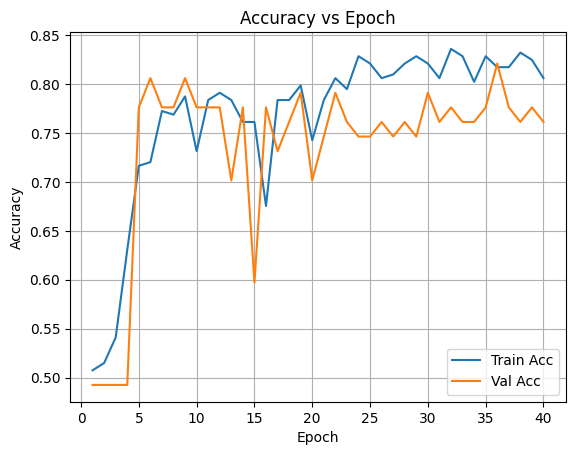

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.67      0.96      0.79        48
LIP-SYNC DEEPFAKE       0.93      0.53      0.68        49

         accuracy                           0.74        97
        macro avg       0.80      0.74      0.73        97
     weighted avg       0.80      0.74      0.73        97

=== CONFUSION MATRIX ===


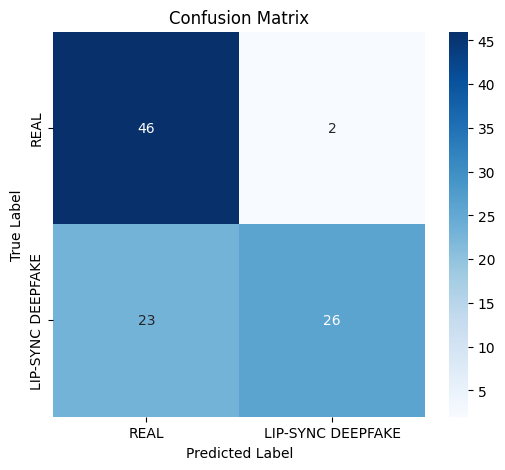

=== ROC AUC ===

📈 AUC Score: 0.8321


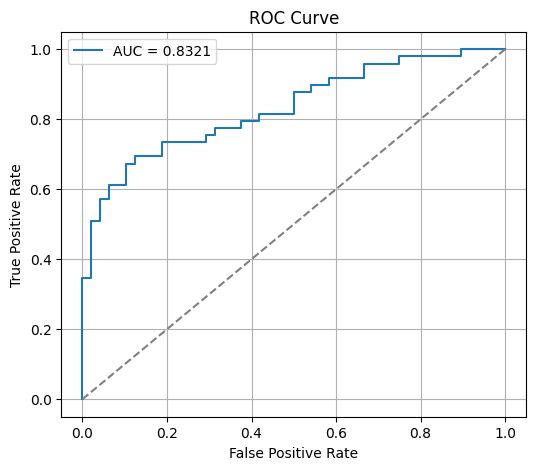

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/ResNet18-BiLSTM_Bibir-Audio/2SequentialResNet18-Bibir_Custom128-Audio_BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
        
        outputs = model(frames, audio)
        
        probs = torch.softmax(outputs, dim=1)
        probs_class1.extend(probs[:, 1].cpu().numpy())

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        pred_labels.extend(preds)
        true_labels.extend(true)
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 4**

ResNet18 : Bibir (4 Sequential Block + 1 BiLSTM)  + Audio (256 Custom CNN + 1 BiLSTM)

1 BiLSTM 

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 512)
        x = x.view(B, T, -1)  # (B, T, 512)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  # pool freq → (B, 128, 1, T)
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=128,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Gabungan dan Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion = nn.LSTM(input_size=512+256, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out, _ = self.temporal_fusion(fused)      # (B, T, 512)
        pooled = fused_out.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/ResNet18-BiLSTM_Bibir-Audio/4SequentialResNet18-Bibir_Custom256-Audio_1-BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/40] Train Loss: 0.6989 | Train Acc: 0.4664 | Val Loss: 0.7163 | Val Acc: 0.3582
Epoch [2/40] Train Loss: 0.6970 | Train Acc: 0.5037 | Val Loss: 0.6949 | Val Acc: 0.4627
Epoch [3/40] Train Loss: 0.6686 | Train Acc: 0.5970 | Val Loss: 0.7985 | Val Acc: 0.4179
Epoch [4/40] Train Loss: 0.5602 | Train Acc: 0.7164 | Val Loss: 0.5434 | Val Acc: 0.7463
Epoch [5/40] Train Loss: 0.4833 | Train Acc: 0.7948 | Val Loss: 0.4438 | Val Acc: 0.8507
Epoch [6/40] Train Loss: 0.4728 | Train Acc: 0.7649 | Val Loss: 0.4638 | Val Acc: 0.7910
Epoch [7/40] Train Loss: 0.4635 | Train Acc: 0.7836 | Val Loss: 0.4438 | Val Acc: 0.8358
Epoch [8/40] Train Loss: 0.4820 | Train Acc: 0.7687 | Val Loss: 0.4360 | Val Acc: 0.8507
Epoch [9/40] Train Loss: 0.4559 | Train Acc: 0.7761 | Val Loss: 0.5194 | Val Acc: 0.7612
Epoch [10/40] Train Loss: 0.4690 | Train Acc: 0.7761 | Val Loss: 0.4270 | Val Acc: 0.8507
Epoch [11/40] Train Loss: 0.4285 | Train Acc: 0.8172 | Val Loss: 0.3916 | Val Acc: 0.8507
Epoch [12/40] Train

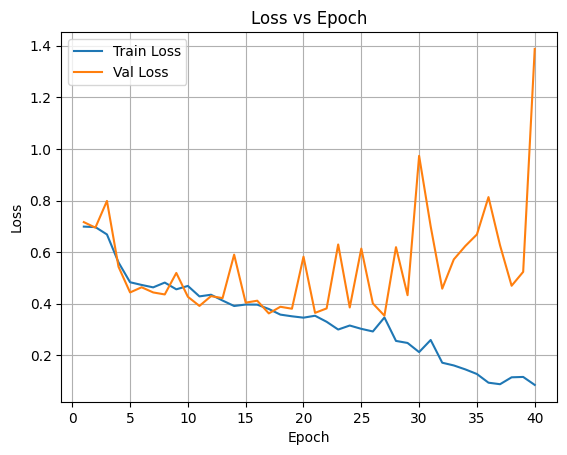

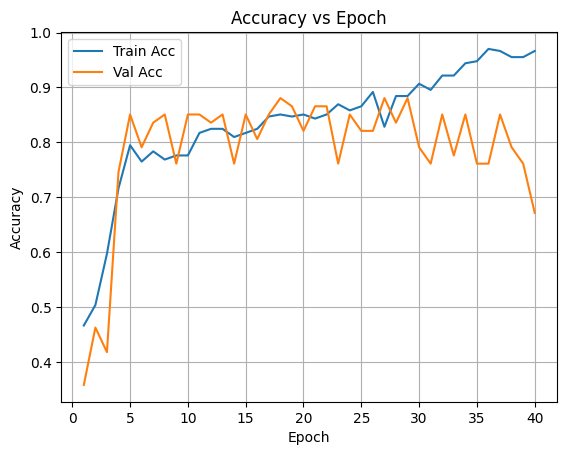

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.67      0.98      0.80        48
LIP-SYNC DEEPFAKE       0.96      0.53      0.68        49

         accuracy                           0.75        97
        macro avg       0.82      0.75      0.74        97
     weighted avg       0.82      0.75      0.74        97

=== CONFUSION MATRIX ===


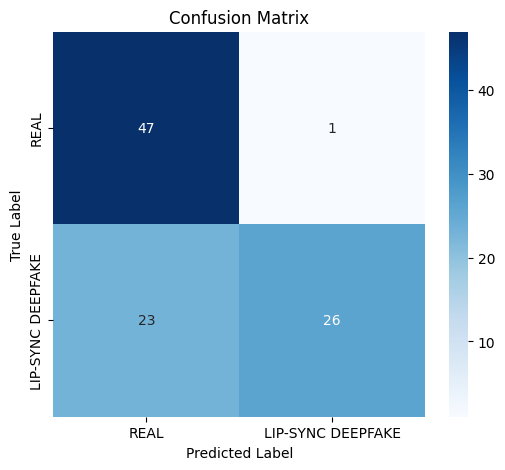

=== ROC AUC ===

📈 AUC Score: 0.8163


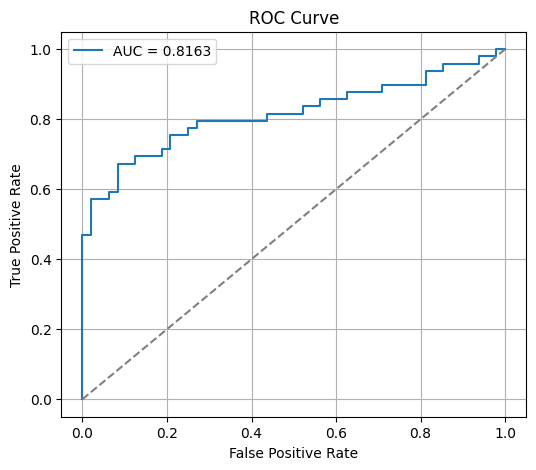

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/ResNet18-BiLSTM_Bibir-Audio/4SequentialResNet18-Bibir_Custom256-Audio_1-BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
        
        outputs = model(frames, audio)
        
        probs = torch.softmax(outputs, dim=1)
        probs_class1.extend(probs[:, 1].cpu().numpy())

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        pred_labels.extend(preds)
        true_labels.extend(true)
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Percobaan 5**

ResNet18 : Bibir (4 Sequential Block + 1 BiLSTM)  + Audio (256 Custom CNN + 1 BiLSTM)

2 BiLSTM 

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

# Model Fitur Ekstraktor Bibir
class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B*T, 512)
        x = x.view(B, T, -1)  # (B, T, 512)
        lstm_out, _ = self.lstm(x)  # (B, T, 512)
        return lstm_out

# Model Fitur Ekstraktor Audio (Custom 256)
class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),  # (B, 64, 128, T)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 128, T)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)), # (B, 128, 128, T)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  # pool freq → (B, 128, 1, T)
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=128,
                            batch_first=True, bidirectional=True)

    def forward(self, x):  # x: (B, 1, 128, T)
        x = self.conv(x)               # (B, 128, 1, T)
        x = x.squeeze(2).permute(0, 2, 1)  # (B, T, 128)
        lstm_out, _ = self.lstm(x)     # (B, T, 256)
        return lstm_out

# Model Gabungan dan Multimodal
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+256, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):  # frames: (B, T, 3, 224, 224), audio: (B, 1, F, T)
        vis_feat = self.visual(frames)     # (B, T, 512)
        aud_feat = self.audio(audio)       # (B, T, 256)

        # Jika length berbeda → interpolasi ke minimal panjang
        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)  # (B, T, 768)
        fused_out1, _ = self.temporal_fusion1(fused)      # (B, T, 512)
        fused_out2, _ = self.temporal_fusion2(fused_out1)      # (B, T, 512)
        pooled = fused_out2.mean(dim=1)                  # (B, 512)
        return self.classifier(pooled)                  # (B, 2)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.eval()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [ ]:
num_epochs = 40
best_val_loss = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for frames, audio, labels in train_loader:
        frames = frames.to(device)             # (B, T, 3, 224, 224)
        audio = audio.to(device)               # (B, 1, F, T)
        labels = labels.to(device)             # (B,)

        optimizer.zero_grad()
        outputs = model(frames, audio)         # (B, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total

    # Validasi
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, audio, labels in val_loader:
            frames = frames.to(device)
            audio = audio.to(device)
            labels = labels.to(device)

            outputs = model(frames, audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Model/ResNet18-BiLSTM_Bibir-Audio/4SequentialResNet18-Bibir_Custom256-Audio_2-BiLSTM.pth')
        
    print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} "
      f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/40] Train Loss: 0.6986 | Train Acc: 0.4366 | Val Loss: 0.6995 | Val Acc: 0.4179
Epoch [2/40] Train Loss: 0.6970 | Train Acc: 0.4925 | Val Loss: 0.6962 | Val Acc: 0.4478
Epoch [3/40] Train Loss: 0.6964 | Train Acc: 0.4776 | Val Loss: 0.6875 | Val Acc: 0.5821
Epoch [4/40] Train Loss: 0.6681 | Train Acc: 0.5560 | Val Loss: 0.7066 | Val Acc: 0.4627
Epoch [5/40] Train Loss: 0.5801 | Train Acc: 0.7276 | Val Loss: 0.4834 | Val Acc: 0.7910
Epoch [6/40] Train Loss: 0.5453 | Train Acc: 0.7276 | Val Loss: 0.4989 | Val Acc: 0.7761
Epoch [7/40] Train Loss: 0.4891 | Train Acc: 0.7761 | Val Loss: 0.4747 | Val Acc: 0.7910
Epoch [8/40] Train Loss: 0.4765 | Train Acc: 0.7985 | Val Loss: 0.4375 | Val Acc: 0.8060
Epoch [9/40] Train Loss: 0.4770 | Train Acc: 0.7948 | Val Loss: 0.4465 | Val Acc: 0.8060
Epoch [10/40] Train Loss: 0.4507 | Train Acc: 0.7836 | Val Loss: 0.4648 | Val Acc: 0.7910
Epoch [11/40] Train Loss: 0.4594 | Train Acc: 0.7910 | Val Loss: 0.4282 | Val Acc: 0.8209
Epoch [12/40] Train

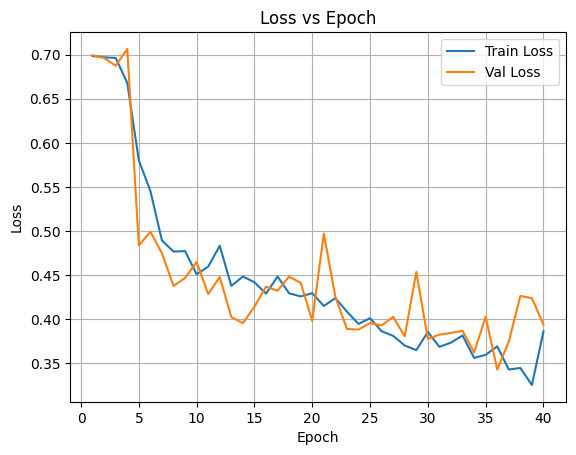

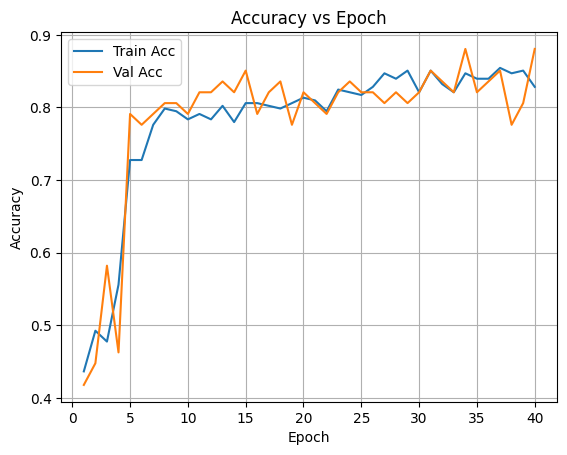

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.67      0.98      0.80        48
LIP-SYNC DEEPFAKE       0.96      0.53      0.68        49

         accuracy                           0.75        97
        macro avg       0.82      0.75      0.74        97
     weighted avg       0.82      0.75      0.74        97

=== CONFUSION MATRIX ===


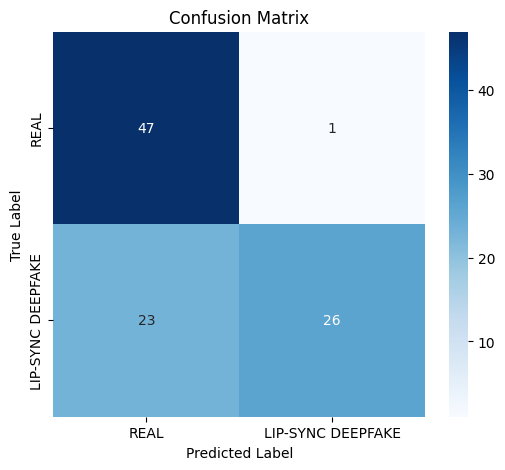

=== ROC AUC ===

📈 AUC Score: 0.8231


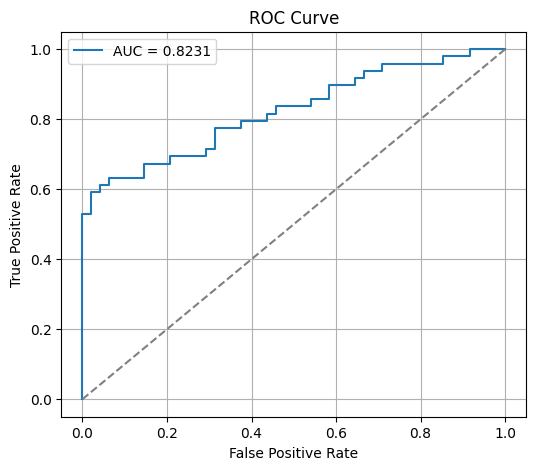

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalLipSyncDetector().to(device)
model.load_state_dict(torch.load('Model/ResNet18-BiLSTM_Bibir-Audio/4SequentialResNet18-Bibir_Custom256-Audio_2-BiLSTM.pth', map_location=device))

test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=collate_fn_pad)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
        outputs = model(frames, audio)
        
        probs = torch.softmax(outputs, dim=1)
        probs_class1.extend(probs[:, 1].cpu().numpy())

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        pred_labels.extend(preds)
        true_labels.extend(true)
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()